In [ ]:
# to-do:

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from focal_loss import SparseCategoricalFocalLoss

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras.applications import Xception

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
COLOR_CHANNELS = 3

In [ ]:
labels = {0:[115, 0, 108],
          1:[122, 1, 145],
          2:[148, 47, 216],
          3:[242, 246, 254],
          4:[130, 9, 181],
          5:[157, 85, 236],
          6:[106, 0, 73],
          7:[168, 123, 248],
          8:[0, 0, 0],
          9:[255, 255, 127],
          10:[142, 255, 127],
          11:[127, 127, 255]}

In [ ]:
def decoded_mask(mask:np.ndarray):
  # mask should be mapped with np.argmax() already
  row, col = mask.shape[0:2]
  b = np.zeros_like(mask)
  g = np.zeros_like(mask)
  r = np.zeros_like(mask)
  b[b == 0] = 8
  g[g == 0] = 8
  r[r == 0] = 8
  for i in range(row):
    for j in range(col):
      for k, pixel in labels.items():
        if mask[i][j] == k:
          b[i][j] = pixel[0]
          g[i][j] = pixel[1]
          r[i][j] = pixel[2]
  single_mask = np.zeros((row, col, 3), dtype=np.uint8)
  single_mask[:,:,0] = b
  single_mask[:,:,1] = g
  single_mask[:,:,2] = r

  return single_mask

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    true_positives = np.sum(y_true_f * y_pred_f)
    false_negatives = np.sum(y_true_f * (1 - y_pred_f))
    false_positives = np.sum((1 - y_true_f) * y_pred_f)

    dice = (2.0 * true_positives + smooth) / (2.0 * true_positives + false_positives + false_negatives + smooth)

    return dice

In [ ]:
def multi_unet_model(n_classes=12, size=16, kernel_initializer='he_normal',IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=3):

 inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
 #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
 s = inputs

 #Contraction path
 c1 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
 #c1 = Dropout(0.1)(c1)
 c1 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
 p1 = MaxPooling2D((2, 2))(c1)

 c2 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
 #c2 = Dropout(0.1)(c2)
 c2 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
 p2 = MaxPooling2D((2, 2))(c2)

 c3 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
# c3 = Dropout(0.2)(c3)
 c3 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
 p3 = MaxPooling2D((2, 2))(c3)

 c4 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
 #c4 = Dropout(0.2)(c4)
 c4 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
 p4 = MaxPooling2D(pool_size=(2, 2))(c4)

 c5 = Conv2D(size * 16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
 #c5 = Dropout(0.3)(c5)
 c5 = Conv2D(size * 16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
 c5 = Dropout(0.5)(c5)

 #Expansive path
 u6 = Conv2DTranspose(size * 8, (2, 2), strides=(2, 2), padding='same')(c5)
 u6 = concatenate([u6, c4])
 c6 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
 #c6 = Dropout(0.2)(c6)
 c6 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

 u7 = Conv2DTranspose(size * 4, (2, 2), strides=(2, 2), padding='same')(c6)
 u7 = concatenate([u7, c3])
 c7 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
 #c7 = Dropout(0.2)(c7)
 c7 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

 u8 = Conv2DTranspose(size * 2, (2, 2), strides=(2, 2), padding='same')(c7)
 u8 = concatenate([u8, c2])
 c8 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
 #c8 = Dropout(0.1)(c8)
 c8 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

 u9 = Conv2DTranspose(size * 1, (2, 2), strides=(2, 2), padding='same')(c8)
 u9 = concatenate([u9, c1], axis=3)
 c9 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
 #c9 = Dropout(0.1)(c9)
 c9 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

 outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

 model = Model(inputs=[inputs], outputs=[outputs])

 return model


In [ ]:
def multi_unet_model_dropout(n_classes=12, size=16, kernel_initializer='he_normal',IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=3):

 inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
 #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
 s = inputs

 #Contraction path
 c1 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
 c1 = Dropout(0.1)(c1)
 c1 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
 p1 = MaxPooling2D((2, 2))(c1)

 c2 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
 c2 = Dropout(0.1)(c2)
 c2 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
 p2 = MaxPooling2D((2, 2))(c2)

 c3 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
 c3 = Dropout(0.2)(c3)
 c3 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
 p3 = MaxPooling2D((2, 2))(c3)

 c4 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
 c4 = Dropout(0.2)(c4)
 c4 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
 p4 = MaxPooling2D(pool_size=(2, 2))(c4)

 c5 = Conv2D(size * 16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
 c5 = Dropout(0.3)(c5)
 c5 = Conv2D(size * 16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

 #Expansive path
 u6 = Conv2DTranspose(size * 8, (2, 2), strides=(2, 2), padding='same')(c5)
 u6 = concatenate([u6, c4])
 c6 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
 c6 = Dropout(0.2)(c6)
 c6 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

 u7 = Conv2DTranspose(size * 4, (2, 2), strides=(2, 2), padding='same')(c6)
 u7 = concatenate([u7, c3])
 c7 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
 c7 = Dropout(0.2)(c7)
 c7 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

 u8 = Conv2DTranspose(size * 2, (2, 2), strides=(2, 2), padding='same')(c7)
 u8 = concatenate([u8, c2])
 c8 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
 c8 = Dropout(0.1)(c8)
 c8 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

 u9 = Conv2DTranspose(size * 1, (2, 2), strides=(2, 2), padding='same')(c8)
 u9 = concatenate([u9, c1], axis=3)
 c9 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
 c9 = Dropout(0.1)(c9)
 c9 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

 outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

 model = Model(inputs=[inputs], outputs=[outputs])

 return model


In [ ]:
model = Xception(include_top=False,
                 input_shape=(256, 256, 3))

for layer in model.layers[86:]:
  layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(3, activation = 'softmax')(x)

transfer_model = tf.keras.Model(inputs=model.input, outputs=x)

In [ ]:
transfer_model.load_weights('')

In [ ]:
model1 = multi_unet_model(size=64)
model2 = multi_unet_model(size=64)
model3 = multi_unet_model(size=64)

models = [model1, model2, model3]

In [ ]:
model_checkpoints = [
    'Kaggle_model\Model_6-Unet64\model64_F_clahe_100e-30bs_MC-vl_data_adam_categoricalcrossentropy_accuracy.hdf5',
    'Kaggle_model\Model_6-Unet64\model64_F_clahe_100e-30bs_data_adam_categoricalcrossentropy_accuracy.hdf5',
    'Kaggle_model\Model_6-Unet64\model64_F_clahe_100e-20bs_MC-vl_data_adam_sparsecategoricalfocalloss_2b_accuracy.hdf5'
]

In [ ]:
X_test = np.load('./Preprocessed-Data (includes Zip)/Data-splits/X_test.npy')
y_test = np.load('./Preprocessed-Data (includes Zip)/Data-splits/y_test.npy')

In [ ]:
trained_model = []
for i, transfer_model in enumerate(models):
    transfer_model.load_weights(model_checkpoints[i])
    trained_model.append(transfer_model)

In [ ]:
predictions = []
for model in trained_model:
    prediction = model.predict(X_test)
    predictions.append(prediction)
    del model

In [ ]:
# memory management
models = None
X_test = None

In [ ]:
# ensembling predictions from 3 model into 1
ensemble_prediction = np.sum(predictions, axis=0)
ensemblePredLabels = np.uint8(ensemble_prediction.argmax(axis=-1))
ensemblePredLabels.shape

In [ ]:
np.save('ensembled_predictions.npy', to_categorical(ensemblePredLabels, num_classes=12, dtype=np.uint8))

In [ ]:
y_test = np.load('./Preprocessed-Data (includes Zip)/Data-splits/y_test.npy')
ensemblePredLabels = np.load('./ensembled_predictions.npy')

In [ ]:
y_test.shape, ensemblePredLabels.shape

((300, 256, 256, 12), (300, 256, 256, 12))

In [ ]:
dice_coef(y_test, ensemblePredLabels)

0.8852338692923516

In [ ]:
decoded_mask(np.argmax(y_test[0], axis=-1)).shape

(256, 256, 3)

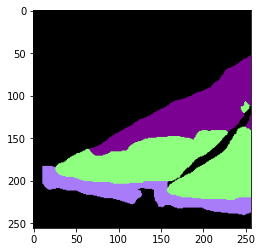

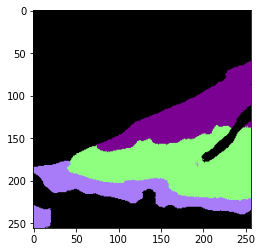

In [ ]:
index = 102

plt.imshow(decoded_mask(np.argmax(y_test[index], axis=-1)))
plt.figure()
plt.imshow(decoded_mask(np.argmax(ensemblePredLabels[index], axis=-1)))

In [ ]:
transfer_model.predict()